# 3 Classes (normal, benign, malignant) Prediction with SVM

A support vector classification machine with the RBF Kernel (C=1 and gamma=0.001) was built here. And two sets of image data were tested with the model. 

+ For Raw DDSM images, SVM model had an overall accuracy of 53.9%.
+ For Threshold images, SVM model had an overall accuracy of 54.3%. 

In [1]:
import datetime
import gc
import numpy as np
import os
import random
from scipy import misc
import string
import time
import sys
import sklearn.metrics as skm
import collections
from sklearn.svm import SVC
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from sklearn import metrics
import dwdii_bc_model_helper_old as bc

random.seed(20275)
np.set_printoptions(precision=2)

## Raw DDSM images

In [2]:
imagePath = "png"
trainDataPath = "data/ddsm_train.csv"
testDataPath = "data/ddsm_test.csv"
imgResize = (150, 150)

In [3]:
os.listdir('data')

['ddsm_test.csv', 'ddsm_train.csv', 'ddsm_val.csv', 'mias_all.csv']

In [4]:
metaData, meta2, mCounts = bc.load_training_metadata(trainDataPath, balanceViaRemoval=True, verbose=True)

Raw Balance
----------------
benign 531
malignant 739
normal 2685
balanaceViaRemoval.avgE: 1318
balanaceViaRemoval.theshold: 1318.0

After Balancing
----------------
benign 531
malignant 739
normal 862


In [5]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_data, Y_data = bc.load_data(trainDataPath, imagePath, 
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize)
print X_data.shape
print Y_data.shape

Raw Balance
----------------
benign 531
malignant 739
normal 2685
balanaceViaRemoval.avgE: 1318
balanaceViaRemoval.theshold: 1318.0

After Balancing
----------------
benign 531
malignant 739
normal 862


dwdii_bc_model_helper_old.py:161: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper_old.py:162: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


0.0000: A_1058_1.LEFT_MLO.LJPEG.png
0.0235: B_3422_1.RIGHT_MLO.LJPEG.png
0.0469: A_0578_1.RIGHT_MLO.LJPEG.png
0.0704: C_0363_1.RIGHT_MLO.LJPEG.png
0.0938: B_3393_1.LEFT_MLO.LJPEG.png
0.1173: C_0192_1.RIGHT_CC.LJPEG.png
0.1407: B_3025_1.LEFT_CC.LJPEG.png
0.1642: A_0313_1.RIGHT_CC.LJPEG.png
0.1876: B_3010_1.RIGHT_MLO.LJPEG.png
0.2111: C_0397_1.LEFT_CC.LJPEG.png
0.2345: A_1082_1.RIGHT_MLO.LJPEG.png
0.2580: C_0190_1.RIGHT_CC.LJPEG.png
0.2814: C_0275_1.LEFT_CC.LJPEG.png
0.3049: C_0367_1.RIGHT_MLO.LJPEG.png
0.3283: C_0370_1.LEFT_CC.LJPEG.png
0.3518: A_0589_1.RIGHT_CC.LJPEG.png
0.3752: A_0522_1.RIGHT_MLO.LJPEG.png
0.3987: B_3509_1.LEFT_CC.LJPEG.png
0.4221: A_0510_1.LEFT_CC.LJPEG.png
0.4456: C_0174_1.RIGHT_CC.LJPEG.png
0.4690: A_1007_1.RIGHT_MLO.LJPEG.png
0.4925: A_0569_1.RIGHT_MLO.LJPEG.png
0.5159: C_0022_1.RIGHT_CC.LJPEG.png
0.5394: C_0488_1.LEFT_CC.LJPEG.png
0.5629: A_0574_1.RIGHT_MLO.LJPEG.png
0.5863: B_3012_1.RIGHT_CC.LJPEG.png
0.6098: B_3110_1.LEFT_CC.LJPEG.png
0.6332: C_0101_1.RIGHT_MLO

In [7]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_test, Y_test = bc.load_data(testDataPath, imagePath, 
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize)
print X_test.shape
print Y_test.shape

Raw Balance
----------------
benign 142
malignant 179
normal 658
balanaceViaRemoval.avgE: 326
balanaceViaRemoval.theshold: 326.0

After Balancing
----------------
benign 142
malignant 179
normal 215
0.0000: B_3380_1.RIGHT_MLO.LJPEG.png
0.0235: A_0090_1.LEFT_MLO.LJPEG.png
0.0469: B_3497_1.LEFT_MLO.LJPEG.png
0.0704: B_3077_1.LEFT_CC.LJPEG.png
0.0938: C_0215_1.LEFT_MLO.LJPEG.png
0.1173: A_0568_1.LEFT_CC.LJPEG.png
0.1407: A_0527_1.LEFT_MLO.LJPEG.png
0.1642: B_3036_1.RIGHT_MLO.LJPEG.png
0.1876: B_3084_1.RIGHT_MLO.LJPEG.png
0.2111: C_0099_1.LEFT_MLO.LJPEG.png
0.2345: B_3013_1.RIGHT_CC.LJPEG.png
(536L, 150L, 150L)
(536L, 1L)


In [8]:
X_train = X_data
Y_train = Y_data

In [9]:
print X_train.shape
print X_test.shape

print Y_train.shape
print Y_test.shape

(2132L, 150L, 150L)
(536L, 150L, 150L)
(2132L, 1L)
(536L, 1L)


In [10]:
def yDist(y):
    bcCounts = collections.defaultdict(int)
    for a in range(0, y.shape[0]):
        bcCounts[y[a][0]] += 1
    return bcCounts

print "Y_train Dist: " + str(yDist(Y_train))
print "Y_test Dist: " + str(yDist(Y_test))

Y_train Dist: defaultdict(<type 'int'>, {0: 862, 1: 531, 2: 739})
Y_test Dist: defaultdict(<type 'int'>, {0: 215, 1: 142, 2: 179})


In [11]:
# Load the bc array for our count in the model definition
bcTypes = bc.bcNumerics()
print bcTypes
print len(bcTypes)

{'benign': 1, 'malignant': 2, 'normal': 0}
3


In [12]:
X_train_s = X_train.reshape((2132,-1))

In [13]:
X_test_s = X_test.reshape((536,-1))

In [14]:
Y_train_s = Y_train.ravel()

In [15]:
model = SVC(C=1.0, gamma=0.001, kernel='rbf')

In [16]:
model.fit(X_train_s,Y_train_s)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
predicted = model.predict(X_test_s)
expected = Y_test

In [18]:
svm_matrix = skm.confusion_matrix(Y_test, predicted)
svm_matrix

array([[115,  35,  65],
       [ 14,  67,  61],
       [ 46,  26, 107]])

In [19]:
print metrics.accuracy_score(expected,predicted)

0.539179104478


In [20]:
numBC = bc.numericBC()
class_names = numBC.values()
np.set_printoptions(precision=2)

In [21]:
# Plot non-normalized confusion matrix
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names,
                      title='Confusion Matrix without normalization')
plt.savefig('raw_class3_o_norm.png')

Confusion matrix, without normalization
[[115  35  65]
 [ 14  67  61]
 [ 46  26 107]]


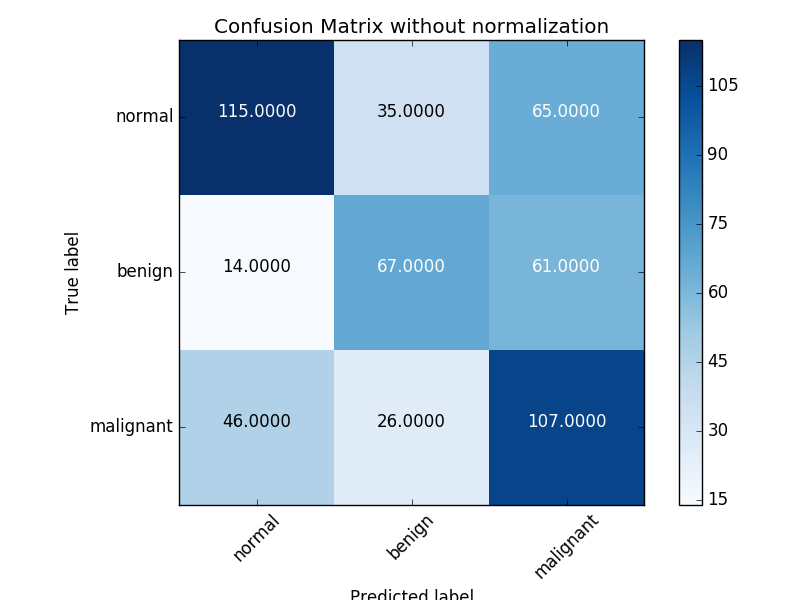

In [22]:
from IPython.display import Image
Image(filename='raw_class3_o_norm.png')

In [23]:
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix with normalization')
plt.savefig('raw_class3_norm.png')

Normalized confusion matrix
[[ 0.53  0.16  0.3 ]
 [ 0.1   0.47  0.43]
 [ 0.26  0.15  0.6 ]]


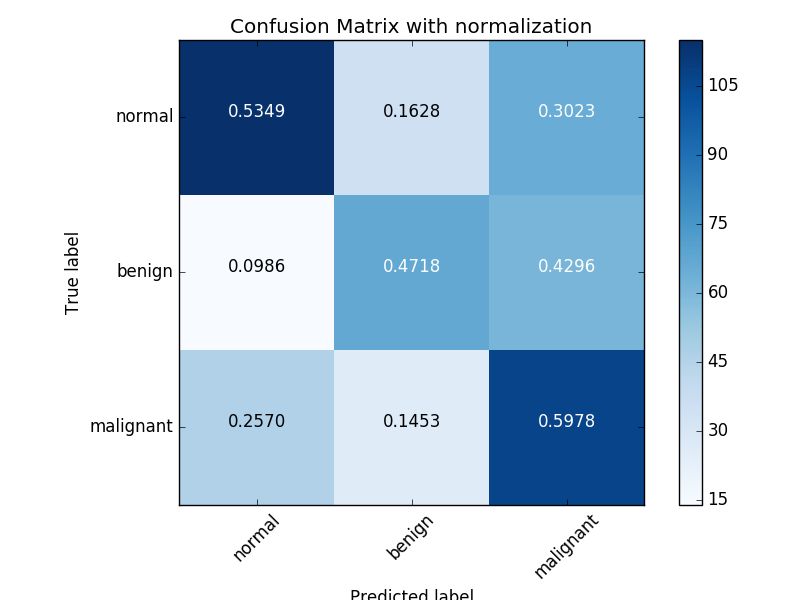

In [24]:
# Load the image we just saved
from IPython.display import Image
Image(filename='raw_class3_norm.png')

## Threshold Images

In [25]:
imagePath = "DDSM_threshold"
trainDataPath = "data/ddsm_train.csv"
testDataPath = "data/ddsm_test.csv"
imgResize = (150, 150)

In [26]:
os.listdir('data')

['ddsm_test.csv', 'ddsm_train.csv', 'ddsm_val.csv', 'mias_all.csv']

In [27]:
metaData, meta2, mCounts = bc.load_training_metadata(trainDataPath, balanceViaRemoval=True, verbose=True)

Raw Balance
----------------
benign 531
malignant 739
normal 2685
balanaceViaRemoval.avgE: 1318
balanaceViaRemoval.theshold: 1318.0

After Balancing
----------------
benign 531
malignant 739
normal 862


In [28]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_data, Y_data = bc.load_data(trainDataPath, imagePath, 
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize)
print X_data.shape
print Y_data.shape

Raw Balance
----------------
benign 531
malignant 739
normal 2685
balanaceViaRemoval.avgE: 1318
balanaceViaRemoval.theshold: 1318.0

After Balancing
----------------
benign 531
malignant 739
normal 862
0.0000: A_0356_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\0\A_0619_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1087_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\0\A_0022_1.RIGHT_MLO.LJPEG.png
0.0235: B_3117_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1010_1.RIGHT_CC.LJPEG.png
0.0469: C_0022_1.RIGHT_MLO.LJPEG.png
0.0704: C_0015_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\0\A_0598_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\0\C_0235_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1016_1.LEFT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1029_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1100_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\1\A_1060_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\1\A_1055_1.LEFT_CC.LJPEG.png
0.0938: B_3411_1.RIGHT_MLO.LJPEG.png

In [29]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_test, Y_test = bc.load_data(testDataPath, imagePath, 
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize)
print X_test.shape
print Y_test.shape

Raw Balance
----------------
benign 142
malignant 179
normal 658
balanaceViaRemoval.avgE: 326
balanaceViaRemoval.theshold: 326.0

After Balancing
----------------
benign 142
malignant 179
normal 215
0.0000: A_1105_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\1\A_1019_1.LEFT_CC.LJPEG.png
0.0235: C_0041_1.LEFT_MLO.LJPEG.png
0.0469: C_0145_1.LEFT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1004_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\1\A_1044_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\3\B_3443_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\0\C_0284_1.LEFT_CC.LJPEG.png
0.0704: A_0391_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\0\A_0303_1.RIGHT_CC.LJPEG.png
0.0938: B_3466_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\1\A_1014_1.LEFT_CC.LJPEG.png
Not Found: DDSM_threshold\3\B_3097_1.RIGHT_MLO.LJPEG.png
Not Found: DDSM_threshold\1\A_1044_1.RIGHT_MLO.LJPEG.png
0.1173: C_0324_1.LEFT_MLO.LJPEG.png
Not Found: DDSM_threshold\3\B_3495_1.RIGHT_CC.LJPEG.png
Not Found: DDSM_threshold\1

In [30]:
X_train = X_data
Y_train = Y_data

print X_train.shape
print X_test.shape

print Y_train.shape
print Y_test.shape

(2024L, 150L, 150L)
(516L, 150L, 150L)
(2024L, 1L)
(516L, 1L)


In [31]:
def yDist(y):
    bcCounts = collections.defaultdict(int)
    for a in range(0, y.shape[0]):
        bcCounts[y[a][0]] += 1
    return bcCounts

print "Y_train Dist: " + str(yDist(Y_train))
print "Y_test Dist: " + str(yDist(Y_test))

Y_train Dist: defaultdict(<type 'int'>, {0: 828, 1: 509, 2: 687})
Y_test Dist: defaultdict(<type 'int'>, {0: 207, 1: 138, 2: 171})


In [32]:
# Load the bc array for our count in the model definition
bcTypes = bc.bcNumerics()
print bcTypes
print len(bcTypes)

{'benign': 1, 'malignant': 2, 'normal': 0}
3


In [34]:
X_train_s = X_train.reshape((2024,-1))
X_test_s = X_test.reshape((516,-1))
Y_train_s = Y_train.ravel()

model = SVC(C=1.0, gamma=0.001, kernel='rbf')

In [35]:
model.fit(X_train_s,Y_train_s)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
predicted = model.predict(X_test_s)
expected = Y_test

In [37]:
svm_matrix = skm.confusion_matrix(Y_test, predicted)
svm_matrix

array([[131,  28,  48],
       [ 33,  71,  34],
       [ 70,  23,  78]])

In [38]:
print metrics.accuracy_score(expected,predicted)

0.542635658915


In [39]:
numBC = bc.numericBC()
class_names = numBC.values()
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names,
                      title='Confusion Matrix without normalization')
plt.savefig('threshold_class3_o_norm.png')

Confusion matrix, without normalization
[[131  28  48]
 [ 33  71  34]
 [ 70  23  78]]


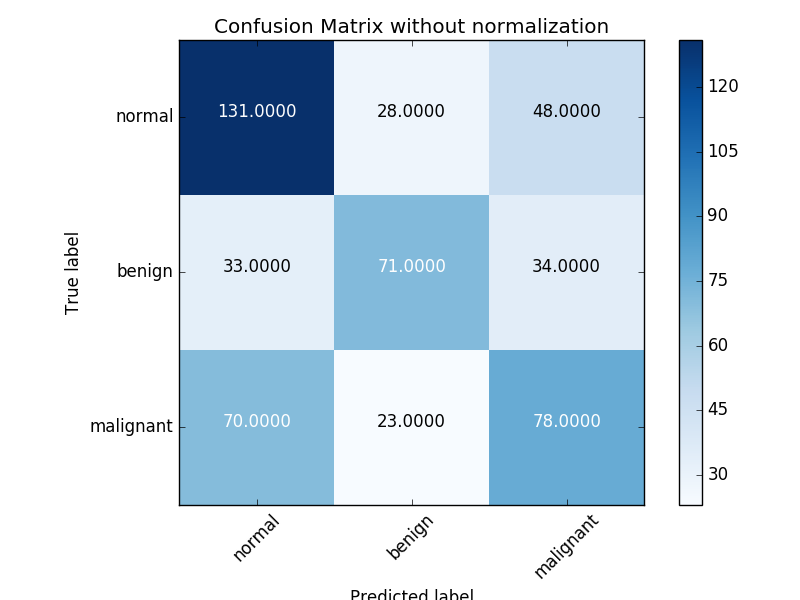

In [40]:
from IPython.display import Image
Image(filename='threshold_class3_o_norm.png')

In [41]:
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix with normalization')
plt.savefig('threshold_class3_norm.png')

Normalized confusion matrix
[[ 0.63  0.14  0.23]
 [ 0.24  0.51  0.25]
 [ 0.41  0.13  0.46]]


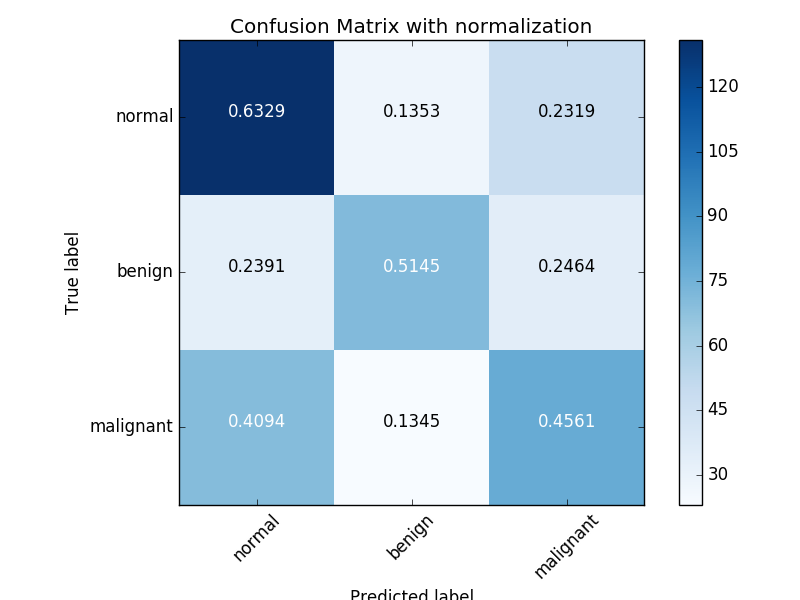

In [42]:
# Load the image we just saved
from IPython.display import Image
Image(filename='threshold_class3_norm.png')